# Benchmark Analysis - H5

In [59]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [60]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [61]:
matplotlib.style.use('seaborn-v0_8')  

In [62]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [63]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [64]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [65]:
plot_save_dir = './plots/h5'

## Utils 

In [66]:
def get_path(*entries):
    return os.path.join(*entries)

In [67]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [68]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [69]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [70]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [71]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [72]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [73]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [74]:

def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [75]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H5
> Parallel stl backends use special parallelism techniques for linear algorithms, which have no clear reference
> implementation, leading to significant differences in terms of performance and their strong scaling properties.


## `b5_1_find_std::vector<int>_first_entry_par`

In [76]:
benchmark_name = "b5_1_find_std::vector<int>_first_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_first_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [77]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_first_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_first_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,4802.55,4,41825.6
1,13480.60,8,40639.8
2,19503.70,16,42547.5
3,22154.20,32,43187.0
4,25591.50,64,44532.8
5,26396.30,128,44628.2
6,30672.90,256,44385.2
7,32554.10,512,44737.6
8,35399.40,1024,49650.1
9,38845.60,2048,44940.0


### Strong Scaling - `b5_1_find_std::vector<int>_first_entry`
 
2^26 fixed input size with threads 1-64

In [78]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_first_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_first_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.000302,0.000028
1,2,0.000547,0.000054
2,4,0.000720,0.000103
3,8,0.000682,0.000177
4,16,0.000761,0.000278
5,32,0.000760,0.000365
6,64,0.000754,0.000441


In [79]:
## efficiency graph

b5_1_find_std_vector_int_first_entry_efficiency = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_first_entry_efficiency['threads']



b5_1_find_std_vector_int_first_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.000302,0.000028
1,2,0.000274,0.000027
2,4,0.000180,0.000026
3,8,0.000085,0.000022
4,16,0.000048,0.000017
5,32,0.000024,0.000011
6,64,0.000012,0.000007


### Plots

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12316/3160213828.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


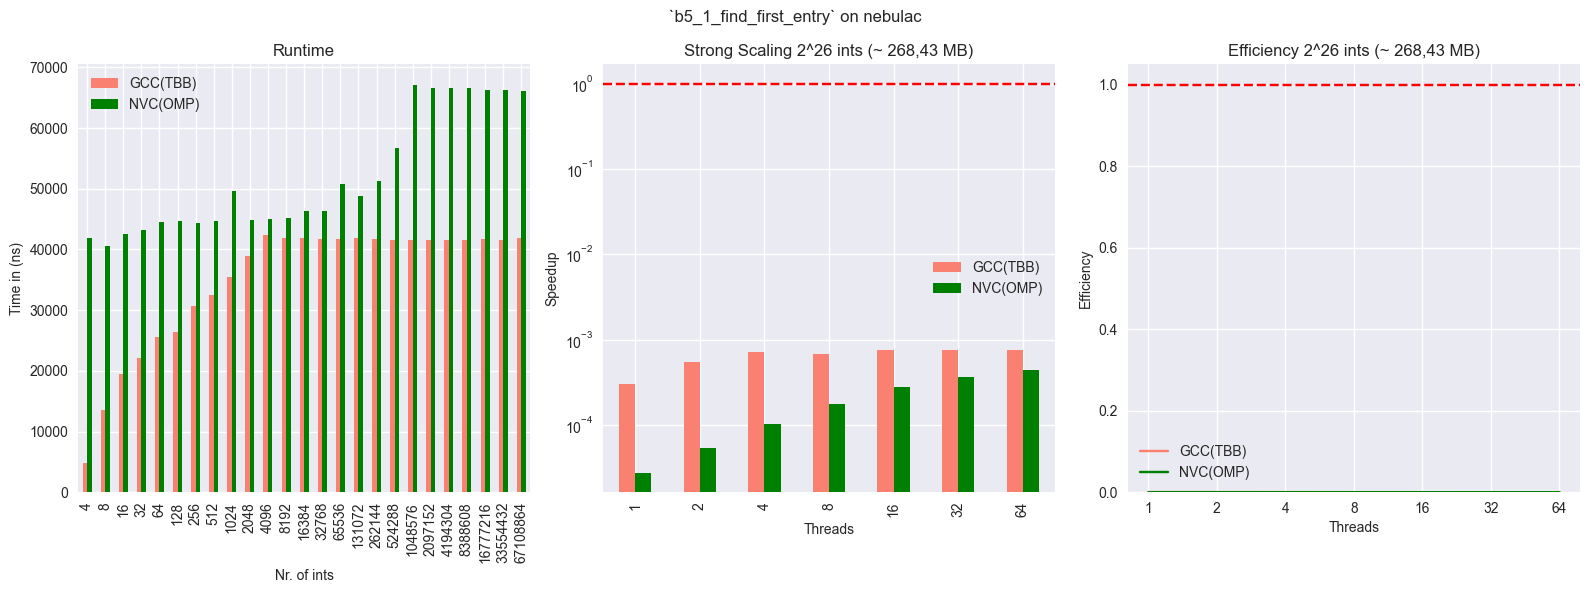

In [80]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_first_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b5_1_find_std_vector_int_first_entry_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_1_find_first_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_first_entry` {device_name}")

## `b5_1_find_std::vector<int>_last_entry_par`

In [81]:
benchmark_name = "b5_1_find_std::vector<int>_last_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_last_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [82]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_last_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_last_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,4708.37,4,41382.8
1,9142.83,8,41849.9
2,14351.10,16,42517.2
3,24875.40,32,43359.7
4,29047.70,64,46180.9
5,32339.50,128,45973.7
6,34090.20,256,45976.5
7,35539.80,512,45487.6
8,37531.40,1024,45498.8
9,40553.60,2048,44113.4


### Strong Scaling - `b5_1_find_std::vector<int>_last_entry`
 
2^26 fixed input size with threads 1-64

In [83]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_last_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_last_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.052635,0.280981
1,2,2.077606,0.553312
2,4,2.876294,1.023163
3,8,4.678691,1.768522
4,16,6.361363,1.808380
5,32,6.971293,1.901514
6,64,7.412854,2.165959


In [84]:
## efficiency graph

b5_1_find_std_vector_int_last_entry_efficiency = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_last_entry_efficiency['threads']



b5_1_find_std_vector_int_last_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.052635,0.280981
1,2,1.038803,0.276656
2,4,0.719073,0.255791
3,8,0.584836,0.221065
4,16,0.397585,0.113024
5,32,0.217853,0.059422
6,64,0.115826,0.033843


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12316/2095068474.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


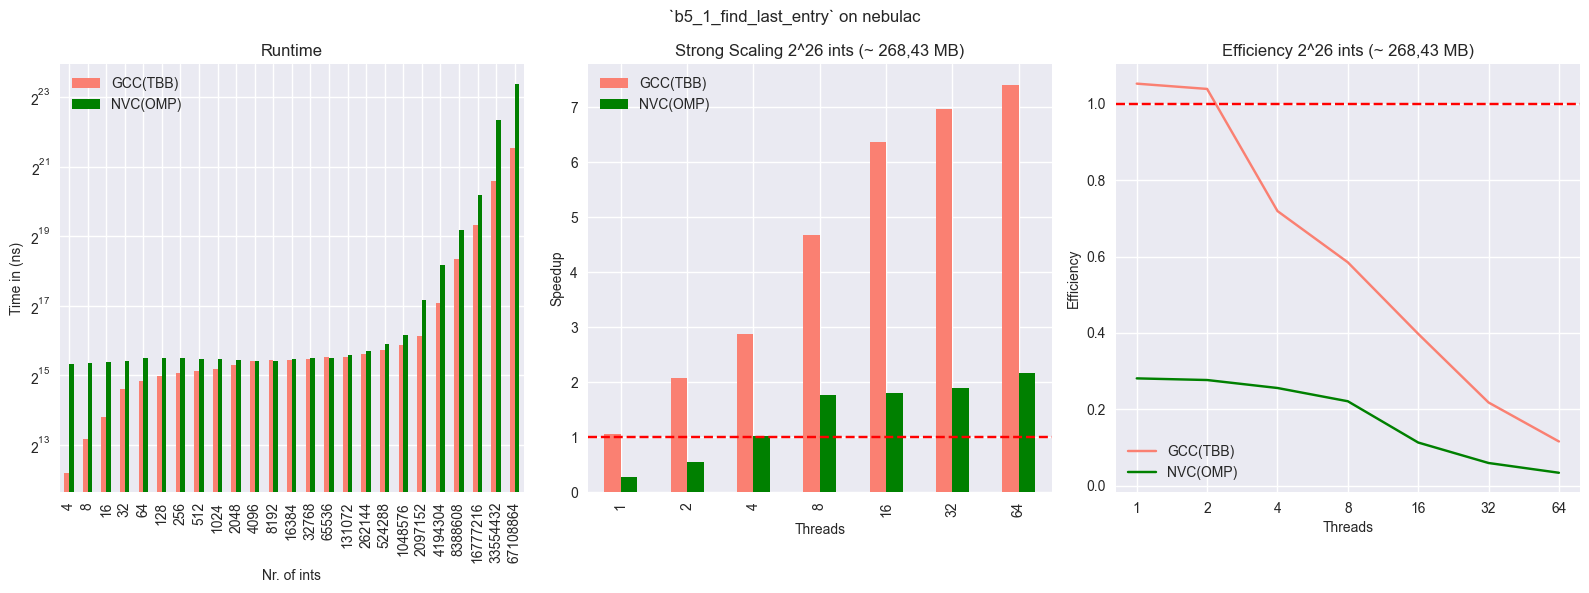

In [85]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_last_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,5)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_last_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle(f"`b5_1_find_last_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_last_entry` {device_name}")

## `b5_1_find_std::vector<int>_non_existing_entry_par`

In [86]:
benchmark_name = "b5_1_find_std::vector<int>_non_existing_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_non_existing_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [87]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_non_existing_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_non_existing_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,5279.28,4,37750.3
1,10746.70,8,39488.6
2,15250.00,16,39750.0
3,20997.80,32,41628.0
4,24768.20,64,42793.8
5,27123.40,128,43401.4
6,28446.90,256,43629.5
7,30805.80,512,42742.2
8,33731.80,1024,42392.1
9,37405.00,2048,42617.8


### Strong Scaling - `b5_1_find_std::vector<int>_non_existing_entry`
 
2^26 fixed input size with threads 1-64

In [88]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.080200,0.284836
1,2,2.136158,0.559486
2,4,2.994475,1.059627
3,8,4.058427,1.772243
4,16,5.880953,1.665685
5,32,6.439311,1.679584
6,64,6.892083,1.555991


In [89]:
## efficiency graph

b5_1_find_std_vector_int_non_existing_entry_efficiency = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_non_existing_entry_efficiency['threads']



b5_1_find_std_vector_int_non_existing_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.080200,0.284836
1,2,1.068079,0.279743
2,4,0.748619,0.264907
3,8,0.507303,0.221530
4,16,0.367560,0.104105
5,32,0.201228,0.052487
6,64,0.107689,0.024312


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12316/2018566896.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


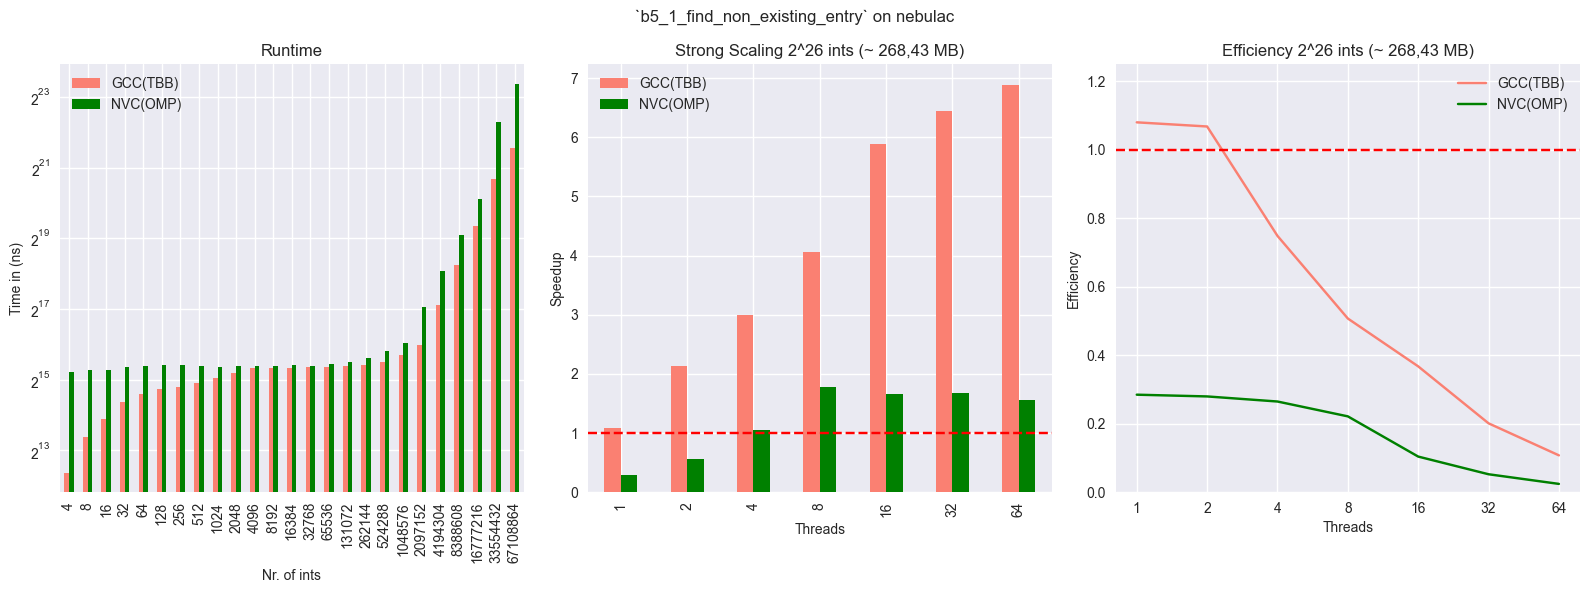

In [90]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_non_existing_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_non_existing_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle(f"`b5_1_find_non_existing_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_non_existing_entry` {device_name}")

## `b5_2_partition_par`

In [91]:
benchmark_name = "b5_2_partition"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_2_partition_par`

Check how the runtime without constraining the threads develops with increasing input size

In [92]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_2_partition_time_merged = pd.merge(*data, on='n')

b5_2_partition_time_merged

,GCC(TBB),n,NVC(OMP)
0,6191.28,4,1.093360e+02
1,12958.60,8,1.814710e+02
2,18533.20,16,3.237620e+02
3,26251.60,32,6.082140e+02
4,30068.20,64,1.177280e+03
5,31889.40,128,2.314620e+03
6,35923.90,256,4.590930e+03
7,40549.20,512,9.144290e+03
8,46686.90,1024,1.824530e+04
9,54768.50,2048,3.645930e+04


### Strong Scaling - `b5_2_partition_strong_par`
 
2^26 fixed input size with threads 1-64

In [93]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_2_partition_strong_scaling_merged = pd.merge(*data, on='threads')

b5_2_partition_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.944413,1.015000
1,2,1.891798,1.014783
2,4,3.785722,1.014125
3,8,7.572287,1.014835
4,16,15.042847,1.014748
5,32,25.635254,1.014082
6,64,50.650955,1.014272


In [94]:
## efficiency graph

b5_2_partition_efficiency = b5_2_partition_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_2_partition_efficiency[f'{compiler_name}'] = b5_2_partition_efficiency[f'{compiler_name}'] / b5_2_partition_efficiency['threads']



b5_2_partition_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.944413,1.015000
1,2,0.945899,0.507391
2,4,0.946430,0.253531
3,8,0.946536,0.126854
4,16,0.940178,0.063422
5,32,0.801102,0.031690
6,64,0.791421,0.015848


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12316/1463862148.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


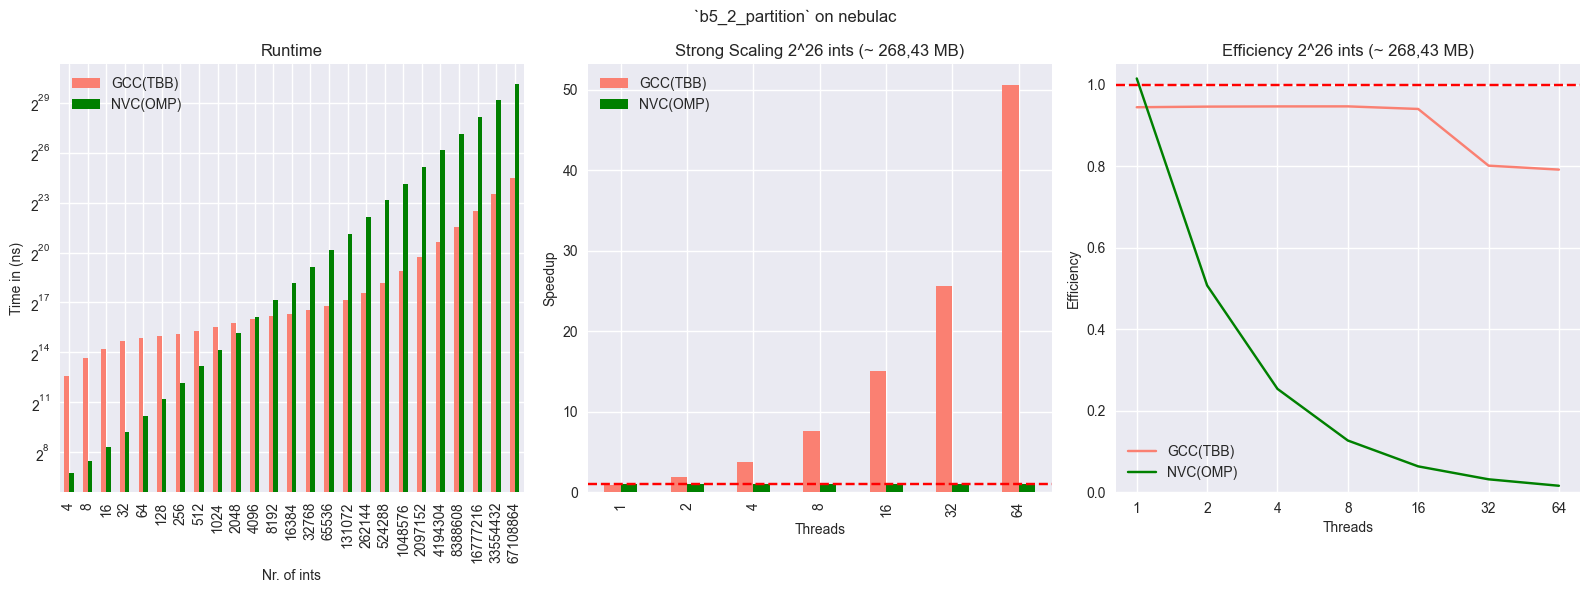

In [95]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_2_partition_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_2_partition_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_2_partition_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_2_partition` on {device_name}")

fig.tight_layout()

plot(f"`b5_2_partition` {device_name}")

## `b5_3_unique_copy_default_par`

In [96]:
benchmark_name = "b5_3_unique_copy_default"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_3_unique_copy_default_par`

Check how the runtime without constraining the threads develops with increasing input size

In [97]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_3_unique_copy_default_time_merged = pd.merge(*data, on='n')

b5_3_unique_copy_default_time_merged

,GCC(TBB),n,NVC(OMP)
0,19332.8,4,19997.8
1,38602.7,8,21709.5
2,56629.5,16,24013.2
3,69928.3,32,23391.3
4,81081.1,64,24319.1
5,88701.8,128,22707.4
6,96417.5,256,22917.5
7,90519.4,512,23842.1
8,96841.3,1024,26968.5
9,96873.6,2048,26213.6


### Strong Scaling - `b5_3_unique_copy_default_strong_par`
 
2^26 fixed input size with threads 1-64

In [98]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_3_unique_copy_default_strong_scaling_merged = pd.merge(*data, on='threads')

b5_3_unique_copy_default_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.340327,0.060238
1,2,0.607680,0.103397
2,4,1.165783,0.162417
3,8,1.793342,0.210007
4,16,2.778470,0.259002
5,32,3.295508,0.279595
6,64,3.587171,0.295954


In [99]:
## efficiency graph

b5_3_unique_copy_default_efficiency = b5_3_unique_copy_default_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_3_unique_copy_default_efficiency[f'{compiler_name}'] = b5_3_unique_copy_default_efficiency[f'{compiler_name}'] / b5_3_unique_copy_default_efficiency['threads']



b5_3_unique_copy_default_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.340327,0.060238
1,2,0.303840,0.051699
2,4,0.291446,0.040604
3,8,0.224168,0.026251
4,16,0.173654,0.016188
5,32,0.102985,0.008737
6,64,0.056050,0.004624


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12316/1087304379.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


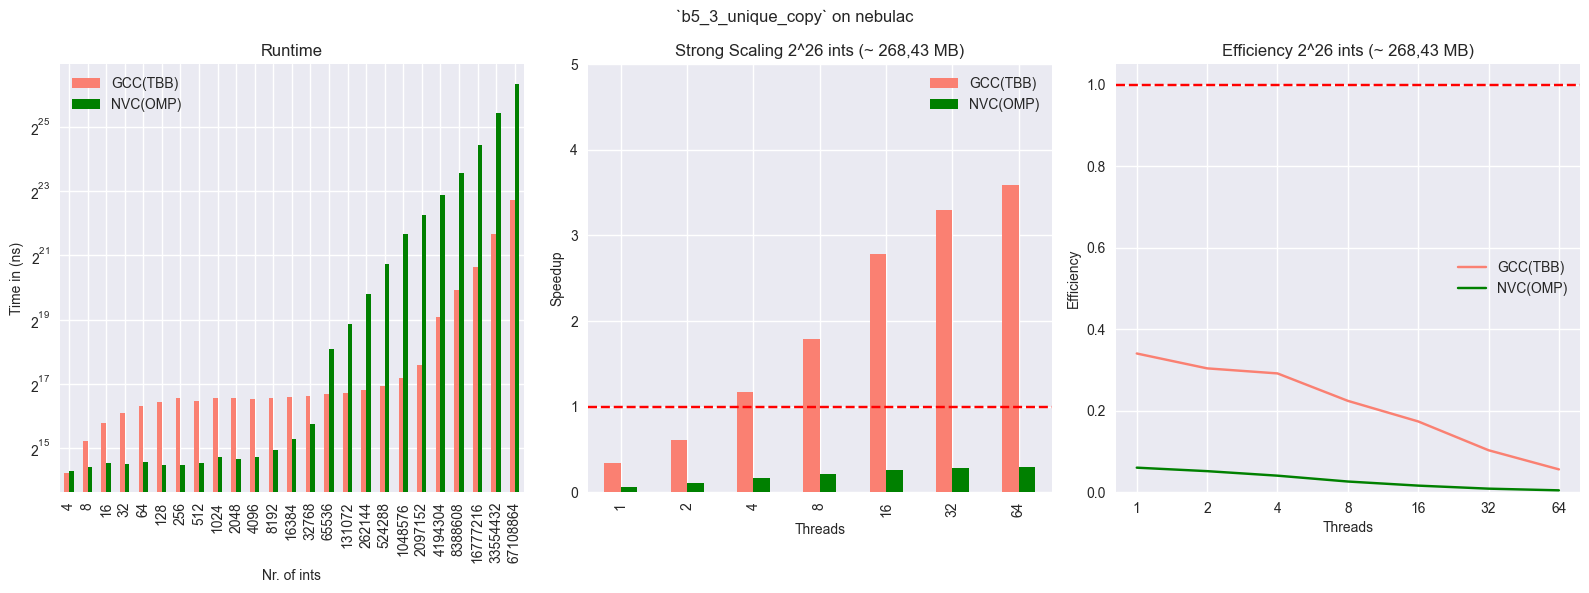

In [100]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_3_unique_copy_default_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_3_unique_copy_default_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,5)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_3_unique_copy_default_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_3_unique_copy` on {device_name}")

fig.tight_layout()

plot(f"`b5_3_unique_copy` {device_name}")

## `b5_4_minmax_element_all_equal_par`

In [101]:
benchmark_name = "b5_4_minmax_element_all_equal"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_all_equal_par`

Check how the runtime without constraining the threads develops with increasing input size

In [102]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_all_equal_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_all_equal_time_merged

,GCC(TBB),n,NVC(OMP)
0,4165.62,4,42474.6
1,10391.80,8,41165.0
2,16083.20,16,40586.9
3,21527.20,32,40793.4
4,25660.90,64,43072.3
5,27676.20,128,46221.8
6,32547.20,256,39923.1
7,36242.40,512,39813.5
8,39981.10,1024,46875.8
9,44023.50,2048,49431.4


### Strong Scaling - `b5_4_minmax_element_all_equal_strong_par`
 
2^26 fixed input size with threads 1-64

In [103]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_all_equal_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_all_equal_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.464147,0.184904
1,2,2.914421,0.369641
2,4,5.761574,0.738991
3,8,11.142902,1.476127
4,16,19.107595,2.948112
5,32,24.902749,4.995151
6,64,26.516538,9.938556


In [104]:
## efficiency graph

b5_4_minmax_element_all_equal_efficiency = b5_4_minmax_element_all_equal_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] = b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] / b5_4_minmax_element_all_equal_efficiency['threads']



b5_4_minmax_element_all_equal_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.464147,0.184904
1,2,1.457211,0.184820
2,4,1.440393,0.184748
3,8,1.392863,0.184516
4,16,1.194225,0.184257
5,32,0.778211,0.156098
6,64,0.414321,0.155290


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12316/535999449.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


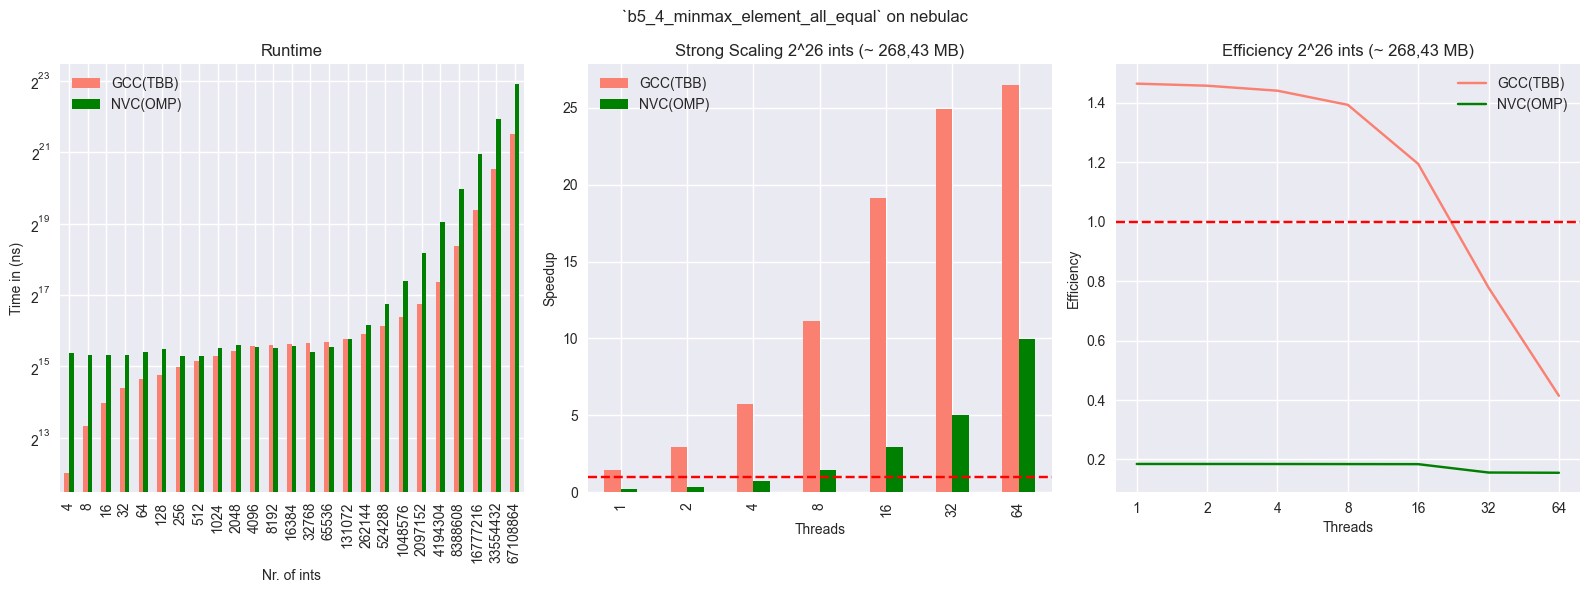

In [105]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_all_equal_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_all_equal_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


#ax_2.set_ylim(0,16)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_all_equal_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_4_minmax_element_all_equal` on {device_name}")

fig.tight_layout()

plot(f"`b5_4_minmax_element_all_equal` {device_name}")

## `b5_4_minmax_element_increasing_par`

In [106]:
benchmark_name = "b5_4_minmax_element_increasing"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_increasing_par`

Check how the runtime without constraining the threads develops with increasing input size

In [107]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_increasing_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_increasing_time_merged

,GCC(TBB),n,NVC(OMP)
0,4200.83,4,43664.0
1,12244.10,8,43466.9
2,17463.30,16,45541.4
3,23257.30,32,46334.4
4,26928.90,64,46381.3
5,31271.60,128,46699.5
6,31690.70,256,46588.1
7,35580.50,512,46672.1
8,40129.10,1024,46792.1
9,44166.30,2048,46844.8


### Strong Scaling - `b5_4_minmax_element_increasing_strong_par`
 
2^26 fixed input size with threads 1-64

In [108]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_increasing_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_increasing_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.462496,0.195075
1,2,2.914220,0.389978
2,4,5.760692,0.779709
3,8,11.013784,1.557377
4,16,19.498756,3.108989
5,32,23.962693,5.079081
6,64,25.235863,10.494035


In [109]:
## efficiency graph

b5_4_minmax_element_increasing_efficiency = b5_4_minmax_element_increasing_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] = b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] / b5_4_minmax_element_increasing_efficiency['threads']



b5_4_minmax_element_increasing_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.462496,0.195075
1,2,1.457110,0.194989
2,4,1.440173,0.194927
3,8,1.376723,0.194672
4,16,1.218672,0.194312
5,32,0.748834,0.158721
6,64,0.394310,0.163969


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12316/1646294840.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


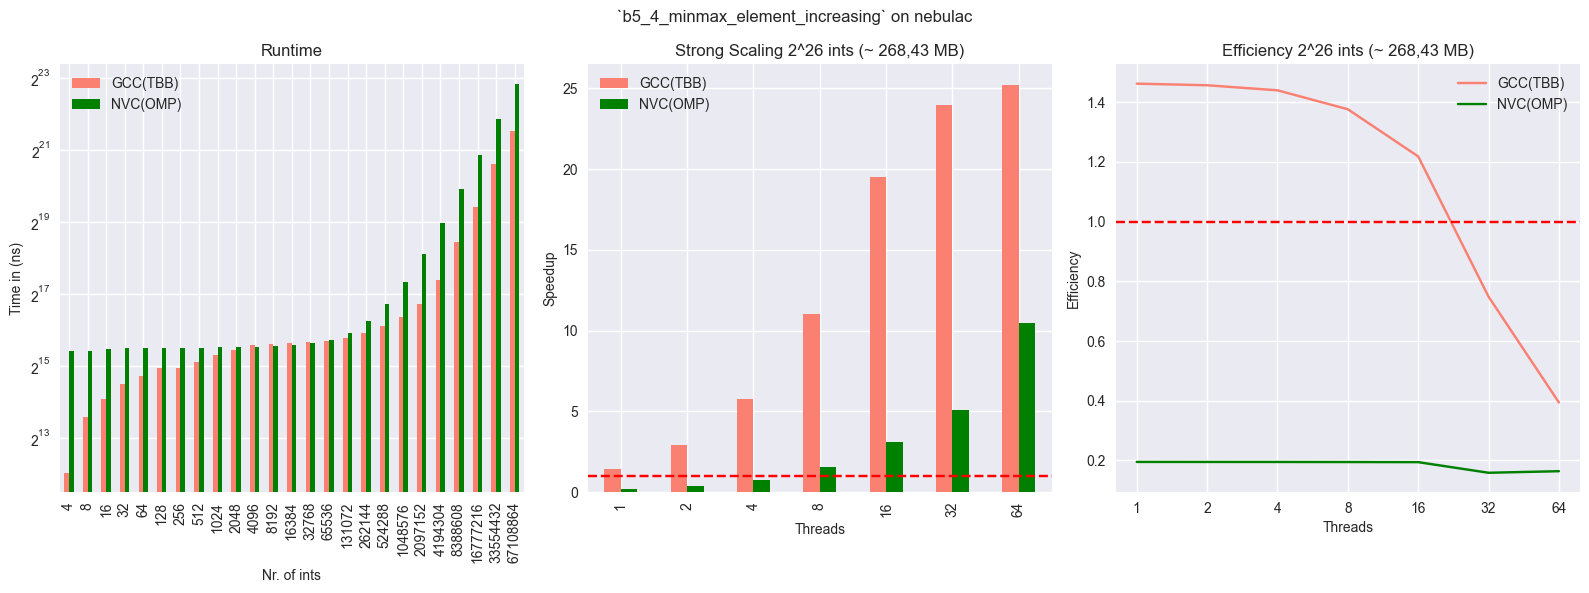

In [110]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_increasing_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_increasing_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,14)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_increasing_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_4_minmax_element_increasing` on {device_name}")

fig.tight_layout()

plot(f"`b5_4_minmax_element_increasing` {device_name}")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime 

In [111]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b5_1_first_entry',b5_1_find_std_vector_int_first_entry_time_merged),
    ('b5_1_last_entry',b5_1_find_std_vector_int_last_entry_time_merged),
    ('b5_1_non_existing',b5_1_find_std_vector_int_non_existing_entry_time_merged),

    ('b5_2_partition',b5_2_partition_time_merged),

    ('b5_3_unique_copy',b5_3_unique_copy_default_time_merged),

    ('b5_4_minmax_element_all_equal',b5_4_minmax_element_all_equal_time_merged),
    ('b5_4_minmax_element_increasing',b5_4_minmax_element_increasing_time_merged),
    
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df



,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b5_1_first_entry,41815,66098,0.774976,BAD
1,b5_1_last_entry,3016240,10973800,0.431198,BAD
2,b5_1_non_existing,3056500,10885900,0.438447,BAD
3,b5_2_partition,23350800,1185360000,0.038638,BAD
4,b5_3_unique_copy,6964700,85379000,0.150843,BAD
5,b5_4_minmax_element_all_equal,2967990,7915880,0.545392,BAD
6,b5_4_minmax_element_increasing,3030110,7500210,0.575502,BAD


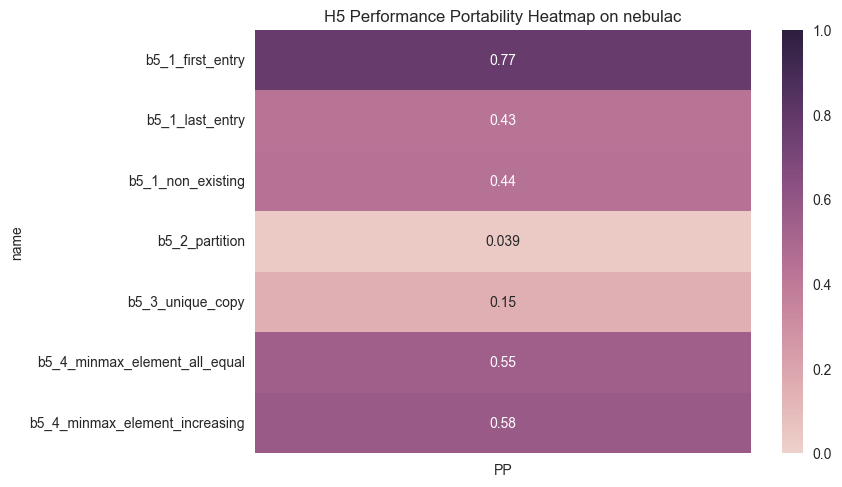

In [112]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H5 Performance Portability Heatmap on {device_name}')

plot(f'H5 Performance Portability Heatmap on {device_name}')

## Findings for H5

### XXX

### General


### GPU Findings


### Hypothesis Findings


